In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from google.colab import drive
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Data import from drive

In [3]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/a/'
file_h1 = base_path + 'House_1_cleaned.csv'
file_h2 = base_path + 'House_2_cleaned.csv'

df1 = pd.read_csv(file_h1, parse_dates=['index'], index_col='index')
df2 = pd.read_csv(file_h2, parse_dates=['index'], index_col='index')

df1.columns = ['House_1_Power']
df2.columns = ['House_2_Power']

print(df1.head())

Mounted at /content/drive
                           House_1_Power
index                                   
2013-02-17 16:00:00+00:00     250.925400
2013-02-17 17:00:00+00:00     633.785217
2013-02-17 18:00:00+00:00     556.098022
2013-02-17 19:00:00+00:00     719.846741
2013-02-17 20:00:00+00:00     634.171387


## Time Series visualization

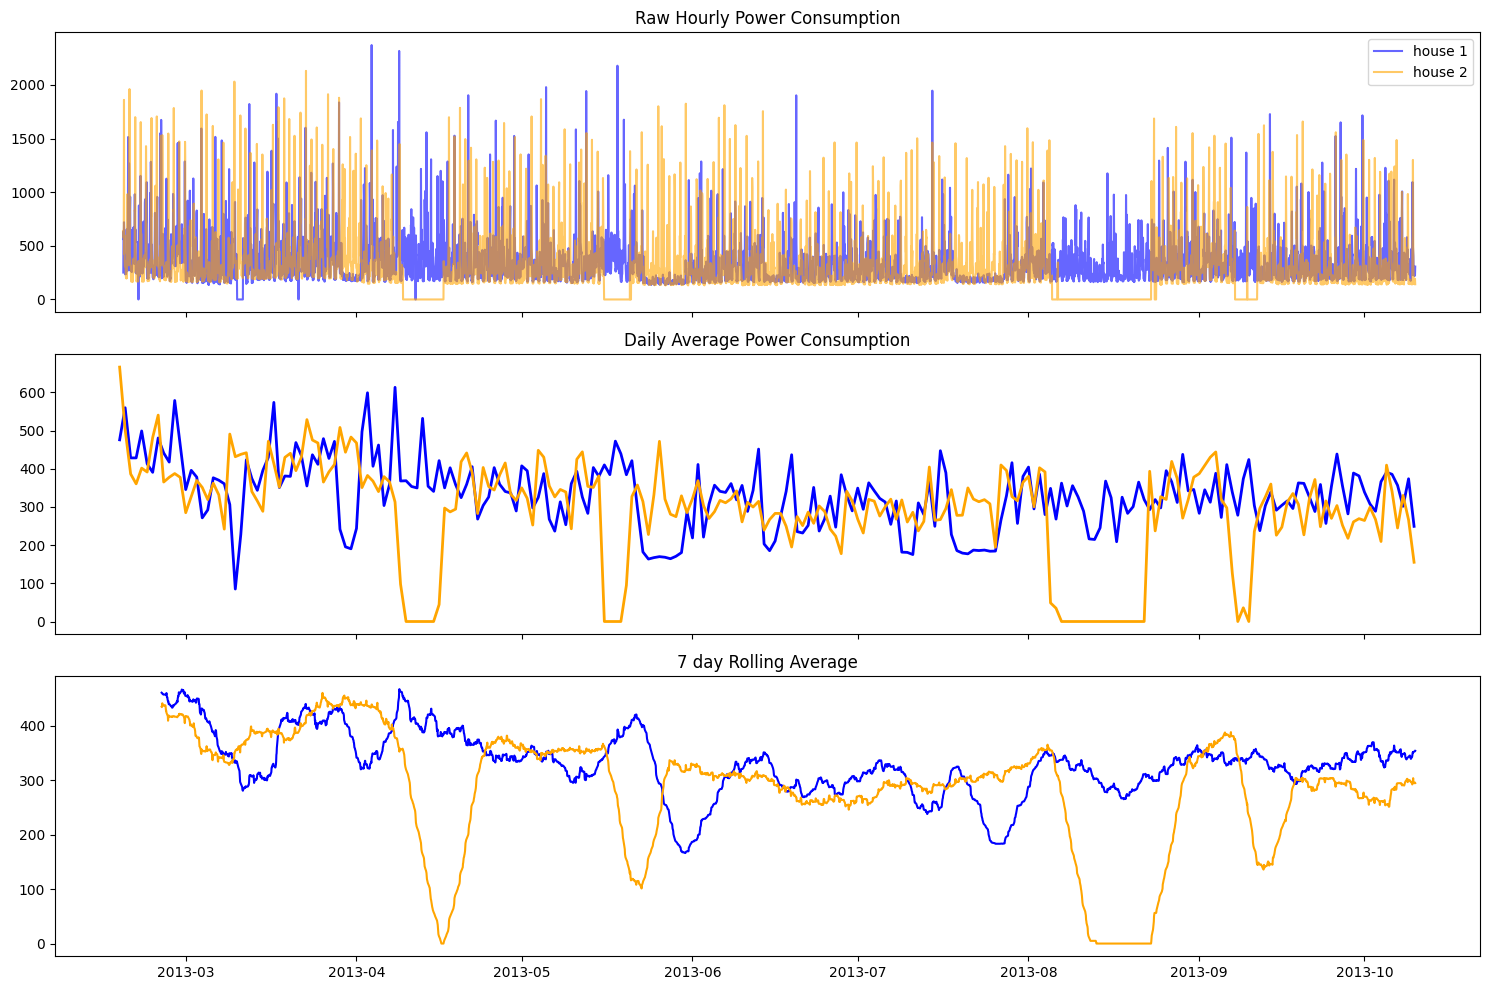

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# Plot 1: Raw hourly data
axes[0].plot(df1.index, df1['House_1_Power'], color='blue', alpha=0.6, label='house 1')
axes[0].plot(df2.index, df2['House_2_Power'], color='orange', alpha=0.6, label='house 2')
axes[0].set_title('Raw Hourly Power Consumption')
axes[0].legend()

# Plot 2: Daily resample
df1_daily = df1.resample('D').mean()
df2_daily = df2.resample('D').mean()
axes[1].plot(df1_daily.index, df1_daily['House_1_Power'], color='blue', linewidth=2)
axes[1].plot(df2_daily.index, df2_daily['House_2_Power'], color='orange', linewidth=2)
axes[1].set_title('Daily Average Power Consumption')

# Plot 3: Weekly rolling average
df1_roll = df1.rolling(window=24*7).mean() # 1 week window
df2_roll = df2.rolling(window=24*7).mean()
axes[2].plot(df1_roll.index, df1_roll['House_1_Power'], color='blue')
axes[2].plot(df2_roll.index, df2_roll['House_2_Power'], color='orange')
axes[2].set_title('7 day Rolling Average')

plt.tight_layout()
plt.show()

## Heatmap and distribution charts to understand seasonality for CNN and LSTM models

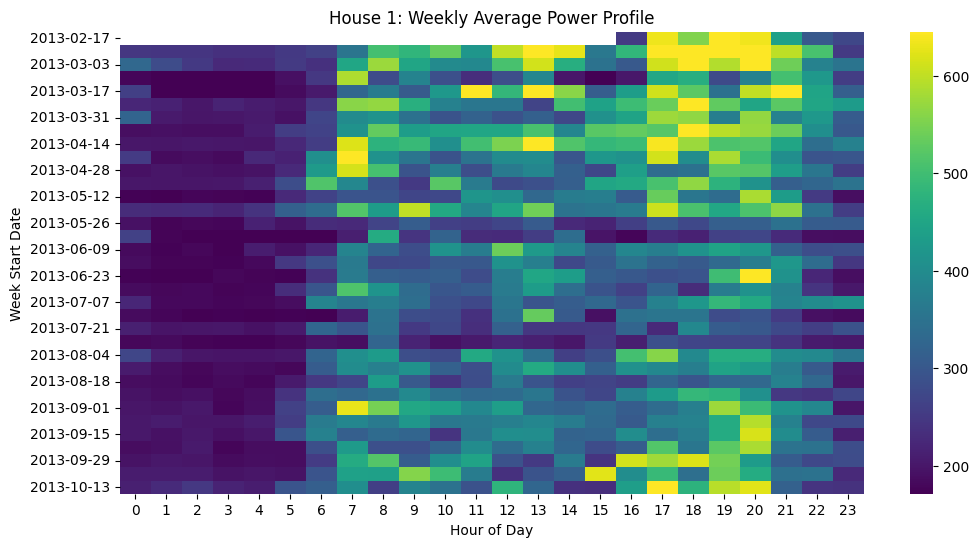

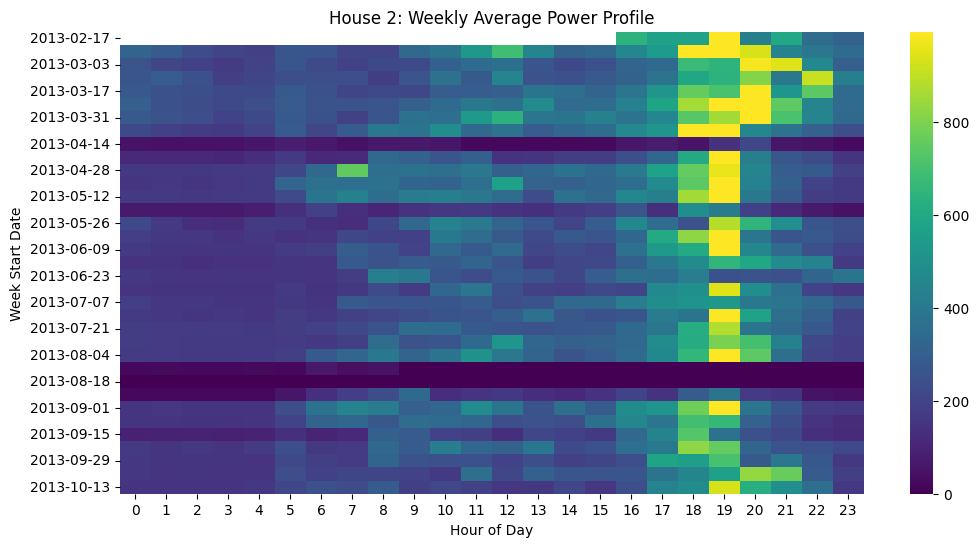

In [5]:
# heatmap to look at hourly and daily seasonaility
# this will help inform the way we construct the CNN model
datasets = [("House 1", df1), ("House 2", df2)]

for name, df in datasets:
    df_temp = df.copy()
    df_temp['Hour'] = df_temp.index.hour

    # Weekly grouping by hour to reduce noise
    weekly_profile = df_temp.groupby([pd.Grouper(freq='W'), 'Hour']).mean()
    heatmap_data = weekly_profile.iloc[:, 0].unstack()
    heatmap_data.index = heatmap_data.index.strftime('%Y-%m-%d')

    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap='viridis', robust=True, annot=False)

    plt.title(f'{name}: Weekly Average Power Profile')
    plt.ylabel('Week Start Date')
    plt.xlabel('Hour of Day')
    plt.yticks(rotation=0)
    plt.show()

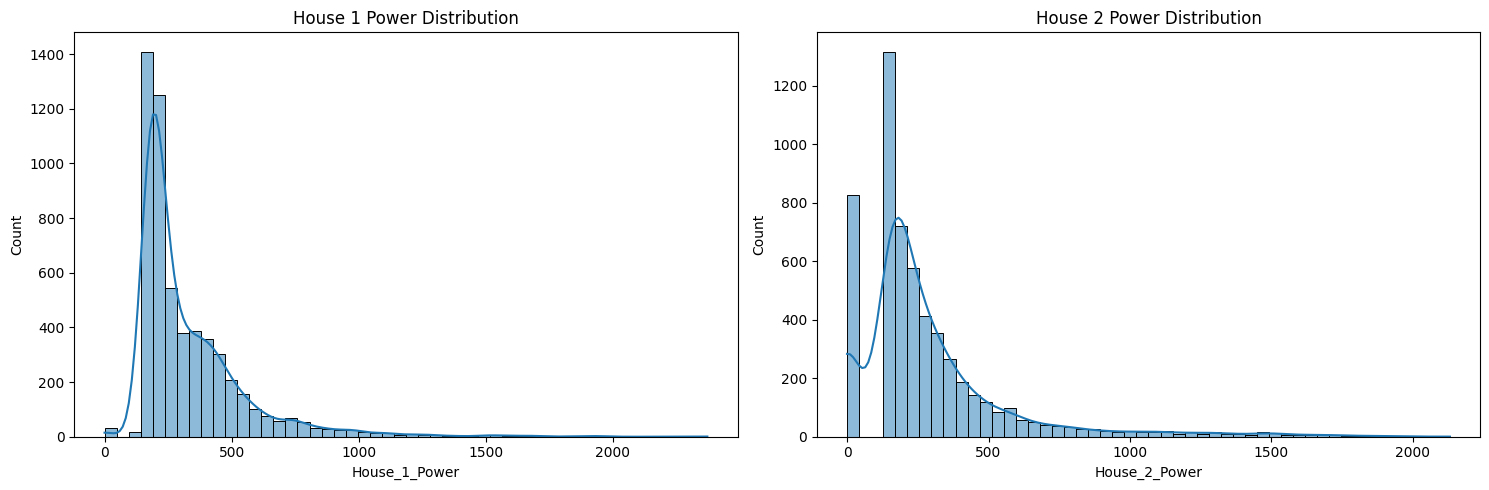

In [8]:
# power distribution histogram to see how power skews across hours
# this will help inform the way we construct the LSTM model
fig, axes = plt.subplots(1, len(datasets), figsize=(15, 5))

if len(datasets) == 1: axes = [axes]

for ax, (name, df) in zip(axes, datasets):
    col_name = df.columns[0]

    sns.histplot(df[col_name], kde=True, ax=ax, bins=50)
    ax.set_title(f'{name} Power Distribution')

plt.tight_layout()
plt.show()